#  <center> Speech Emotion Recognition <center>

Datasets contains 8 types of emotions:

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Datasets used:
1.Ravdess
2.Savee
3.TESS

In [41]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
Creating a dataframe storing all emotions of the data in dataframe with their paths. I will use this dataframe to extract features for our model training.

In [26]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [29]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that auido.
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
#emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
#path_df = pd.DataFrame(file_path, columns=['Path'])
#Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions  Statement                                               Path
0  surprise          1  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral          1  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust          1  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust          1  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral          2  /kaggle/input/ravdess-emotional-speech-audio/a...

In [30]:
Ravdess_df.shape

(1440, 3)

In [31]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement   1   2
Emotions         
angry      96  96
calm       96  96
disgust    96  96
fear       96  96
happy      96  96
neutral    48  48
sad        96  96
surprise   96  96

In [32]:
# creating a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

## Data Visualisation and Exploration

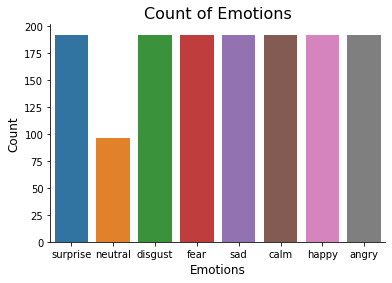

In [33]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

In [50]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

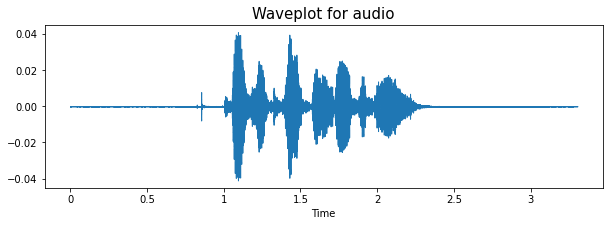

In [51]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

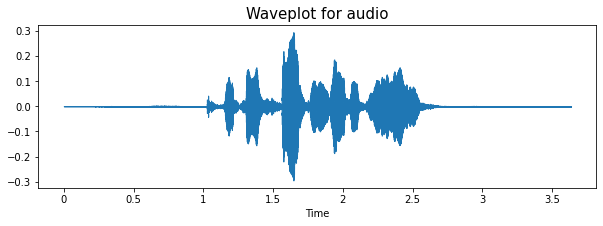

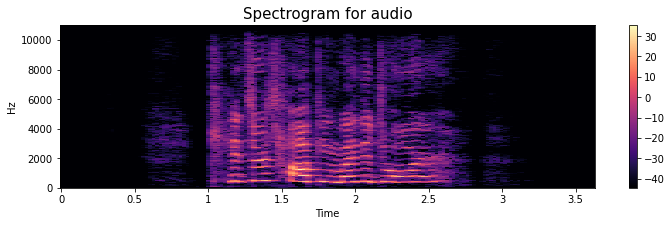

In [54]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

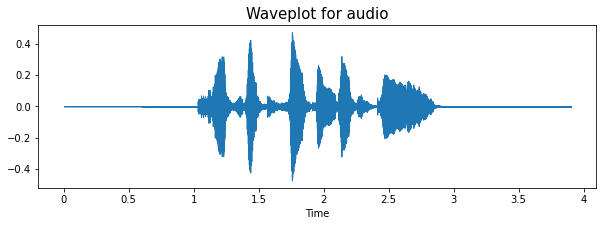

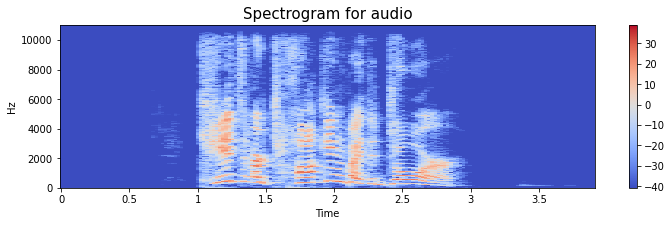

In [55]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

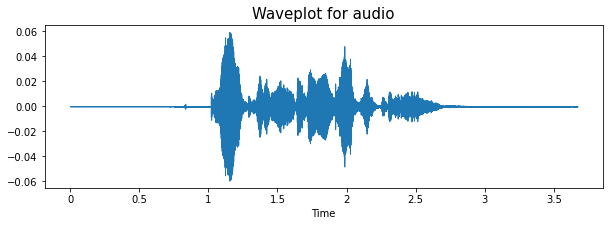

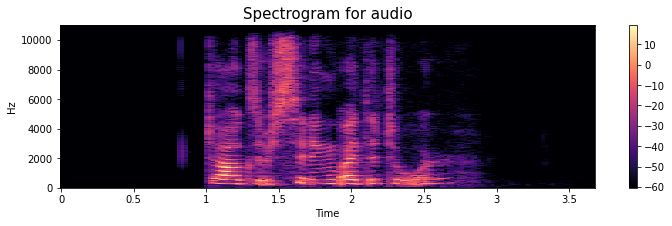

In [56]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

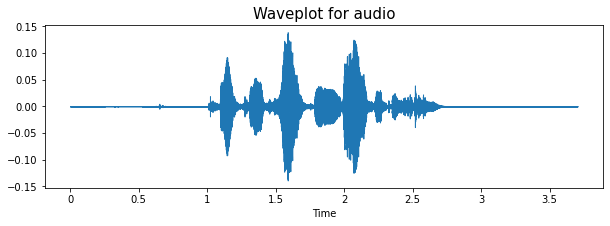

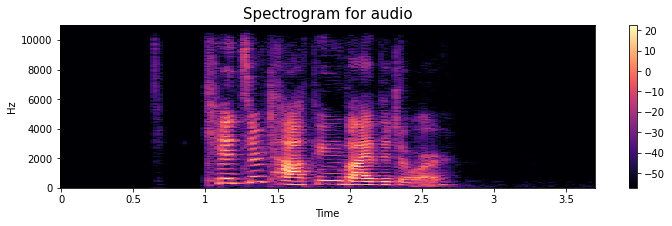

In [57]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

## Data Augmentation

- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- Using Random transformations and augmenting data before training.

In [58]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

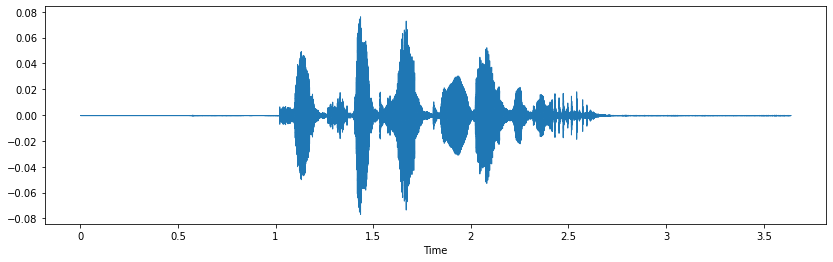

In [60]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

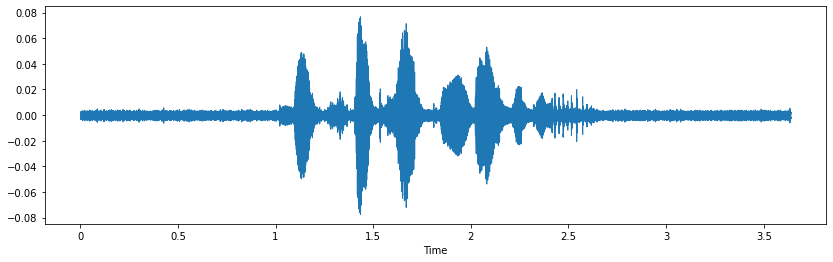

In [61]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

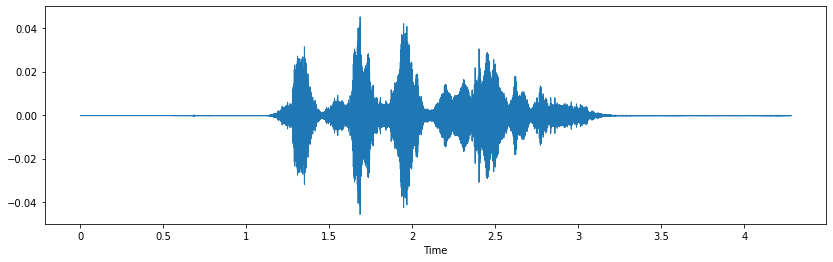

In [62]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

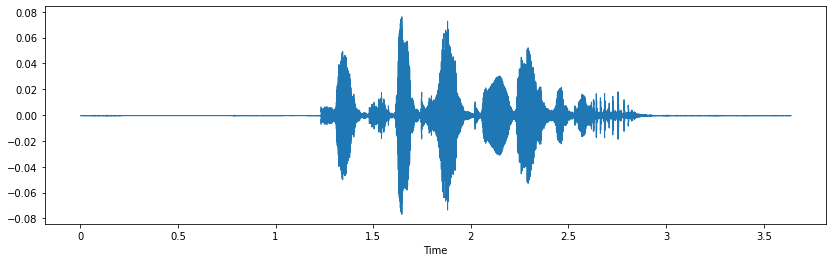

In [63]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

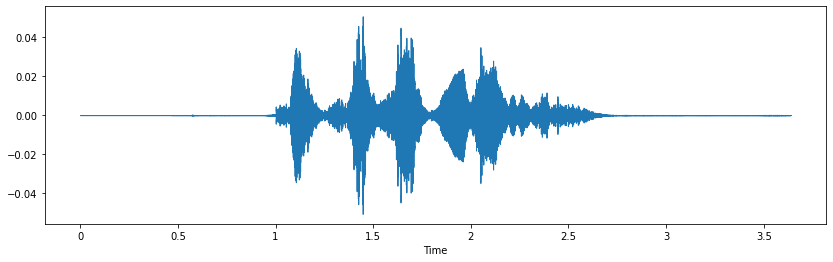

In [64]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
With the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it. Extracting MFCC for the current experiment.

> MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [69]:
def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

# funtion to transform audio
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


    #randomly transforming audio data
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)#np.vstack((result, res2)) # stacking vertically

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)#np.vstack((result, res3)) # stacking vertically

    return result

In [72]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape

#xx = extract_features(data)
#fns = [noise, stretch, pitch]
#xx1 = extract_features(stretch(data))
#xx.shape, xx1.shape
#xx = get_features(path)
#len(xx)

((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [73]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 104)
(20, 104)
(20, 104)
(20, 101)
(20, 101)
(20, 101)
(20, 107)
(20, 107)
(20, 107)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)


In [74]:
len(X), len(Y), data_path.Path.shape

(4275, 4275, (1440,))

In [76]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [77]:
Features = dfm.copy()
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

0  \
0  [-842.3755, -811.6638, -767.0175, -718.32983, ...   
1  [-780.69904, -775.2112, -742.30334, -696.2332,...   
2  [-366.3612623068094, -336.46908281883947, -352...   
3  [-913.6294, -913.7325, -914.4379, -913.22504, ...   
4  [-829.4548, -829.4548, -829.4548, -829.4548, -...   

                                                   1  \
0  [-0.7242323, -18.475267, -31.59216, -32.44238,...   
1  [0.0, -3.7225056, -18.492428, -31.023434, -26....   
2  [2.5701893215712417, 3.365444717609158, 1.6800...   
3  [-0.7014768, -0.5792295, 0.0, 1.2553209, 2.026...   
4  [0.0, 0.0, 0.0, 0.0, 0.1798634, 0.0, 0.4899245...   

                                                   2  \
0  [1.1959844, 5.258437, -0.5301509, -15.42464, -...   
1  [0.0, 2.318462, 2.44322, -10.184084, -28.89537...   
2  [-8.163590311407205, -8.88720632983901, -13.72...   
3  [0.5126029, 0.42965204, 0.0, 0.8279608, 1.1580...   
4  [0.0, 0.0, 0.0, 0.0, 0.11058958, 0.0, 0.312134...   

                                                   3  \
0  [0.14296375, 8.515469, 25.454031, 33.406044, 3...   
1  [0.0, 0.06972754, 10.677166, 28.789684, 27.681...   
2  [8.208244679732314, 6.112670703296702, 3.37913...   
3  [0.15981093, 0.1509968, 0.0, -0.027427018, -0....   
4  [0.0, 0.0, 0.0, 0.0, 0.014201462, 0.0, 0.06208...   

                                                   4  \
0  [0.48472396, 2.394704, 3.7548923, 2.37531, -1....   
1  [0.0, 1.157292, 4.0766087, 5.833069, 1.0642719...   
2  [-6.179343546001361, -9.910014725862833, -12.0...   
3  [-0.6724916, -0.61410666, 0.0, -0.9112507, -1....   
4  [0.0, 0.0, 0.0, 0.0, -0.08563587, 0.0, -0.2021...   

                                                   5  \
0  [0.75833946, -1.8518243, -8.903948, -14.993216...   
1  [0.0, 1.1284783, -3.1562037, -9.796624, -12.73...   
2  [2.996632022296396, 5.112185859581915, 5.20343...   
3  [0.8460416, 0.7131464, 0.0, -1.2751017, -2.062...   
4  [0.0, 0.0, 0.0, 0.0, -0.16442353, 0.0, -0.4192...   

                                                   6  \
0  [-0.13237578, -7.9684086, -19.853508, -25.6599...   
1  [0.0, -3.1943297, -12.803915, -20.682457, -20....   
2  [-13.060131251144671, -12.365269086360474, -9....   
3  [-1.0928643, -0.9329289, 0.0, -1.6983411, -2.3...   
4  [0.0, 0.0, 0.0, 0.0, -0.20283288, 0.0, -0.5389...   

                                                   7  \
0  [1.1537762, 7.0290775, 8.012272, 10.48918, 10....   
1  [0.0, 2.7055101, 3.9245877, 1.6383834, 5.66721...   
2  [3.910143308786531, 5.095724961672378, 6.77332...   
3  [0.5172091, 0.39940697, 0.0, -1.2130009, -1.90...   
4  [0.0, 0.0, 0.0, 0.0, -0.19146429, 0.0, -0.5336...   

                                                   8  \
0  [-0.05430014, -0.96170884, 2.8068533, 7.922286...   
1  [0.0, -0.05885993, 1.6160661, 4.643632, 9.0091...   
2  [-4.354646774674246, -5.098977747694964, -5.43...   
3  [-0.30648595, -0.19255772, 0.0, -0.72878, -1.0...   
4  [0.0, 0.0, 0.0, 0.0, -0.13313496, 0.0, -0.4047...   

                                                   9  ...  \
0  [0.74274725, 0.8992811, -1.08971, 3.0613022, 9...  ...   
1  [0.0, -0.62967867, -0.9115901, 1.8073897, 6.19...  ...   
2  [9.850830990556805, 8.280911206635086, 7.81094...  ...   
3  [-0.46187282, -0.43680447, 0.0, 0.08114779, 0....  ...   
4  [0.0, 0.0, 0.0, 0.0, -0.042218924, 0.0, -0.182...  ...   

                                                  11  \
0  [0.5776906, 9.093815, 16.259195, 15.61842, 12....   
1  [0.0, 1.6613699, 9.030531, 9.3513565, 9.998842...   
2  [0.29968022050272636, 2.461863615683589, 6.418...   
3  [-0.9346846, -0.7847467, 0.0, 1.2714024, 2.003...   
4  [0.0, 0.0, 0.0, 0.0, 0.14557478, 0.0, 0.326180...   

                                                  12  \
0  [0.45054242, 6.032459, 12.067149, 15.393202, 1...   
1  [0.0, 1.0499923, 9.874021, 15.464731, 20.82209...   
2  [-3.730867700163702, -6.323602580999838, -9.66...   
3  [0.9477358, 0.75320137, 0.0, 1.6479173, 2.2172...   
4  [0.0, 0.0, 0.0, 0.0, 0.19636726

In [78]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((4275, 20, 108), (4275,))

## Data Preparation

In [79]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [80]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 20, 108), (3420, 8), (855, 20, 108), (855, 8))

In [81]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 108, 20, 1, 1), (3420, 8), (855, 108, 20, 1, 1), (855, 8))

## Modelling

In [82]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(108, 20, 1, 1)

In [83]:
model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2,1))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

model.summary()

2022-12-08 17:22:42.514938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:22:42.516088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:22:42.898534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:22:42.899455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 17:22:42.900315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 108, 20, 1, 16)    64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 108, 20, 1, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 108, 320)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                45184     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [84]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

2022-12-08 17:22:53.512134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-08 17:22:57.010015: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 15s 36ms/step - loss: 2.0337 - accuracy: 0.1784 - val_loss: 2.0220 - val_accuracy: 0.1754
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 1.9343 - accuracy: 0.2363 - val_loss: 1.9693 - val_accuracy: 0.2561
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 1.8385 - accuracy: 0.2871 - val_loss: 1.8691 - val_accuracy: 0.2760
Epoch 4/100
27/27 [==============================] - 0s 13ms/step - loss: 1.7537 - accuracy: 0.3348 - val_loss: 1.7800 - val_accuracy: 0.3357
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 1.6699 - accuracy: 0.3620 - val_loss: 1.6149 - val_accuracy: 0.3836
Epoch 6/100
27/27 [==============================] - 0s 13ms/step - loss: 1.6153 - accuracy: 0.3977 - val_loss: 1.6251 - val_accuracy: 0.3942
Epoch 7/100
27/27 [==============================] - 0s 13ms/step - loss: 1.5598 - accuracy: 0.4260 - val_loss: 1.5621 - val_accuracy: 0.4047
Epoch 8/100
27/27

27/27 [==============================] - 0s 12ms/step - loss: 0.8445 - accuracy: 0.7380
Accuracy of our model on test data :  73.80117177963257 %


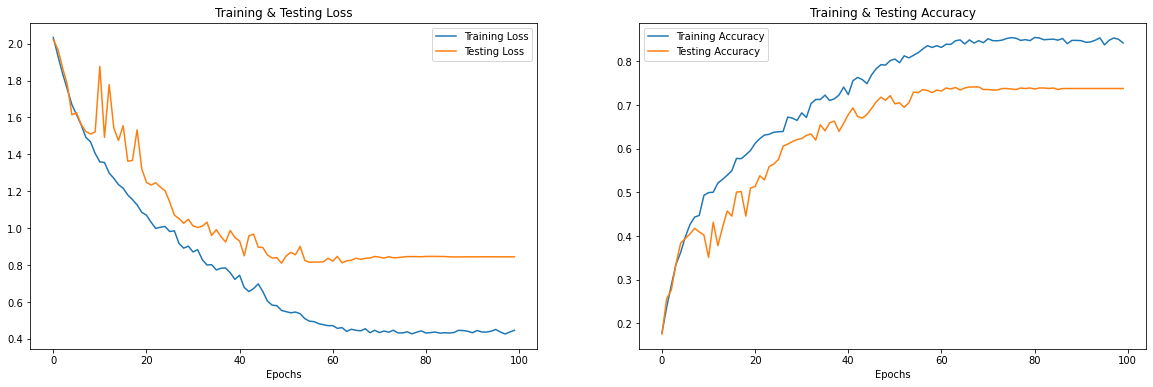

In [85]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [86]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [87]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0         surprise      surprise
1            angry       disgust
2            angry         angry
3            angry         angry
4         surprise      surprise
5         surprise         happy
6             fear          fear
7            happy         happy
8          neutral       neutral
9          disgust       disgust

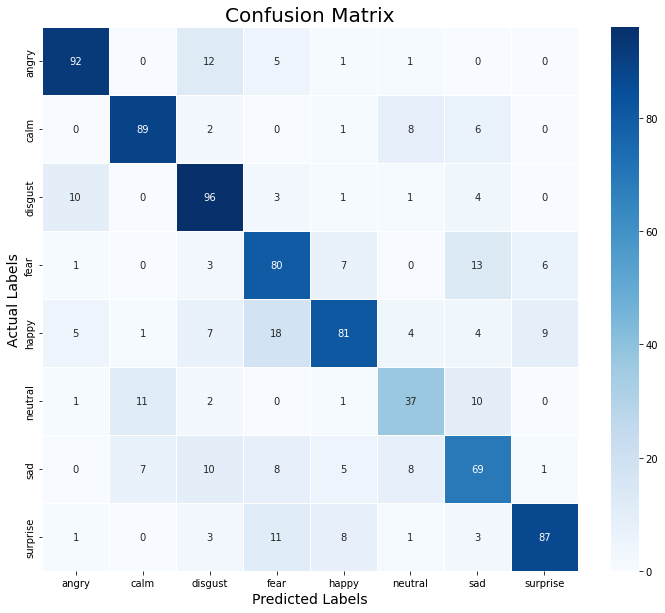

In [88]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.84      0.83      0.83       111
        calm       0.82      0.84      0.83       106
     disgust       0.71      0.83      0.77       115
        fear       0.64      0.73      0.68       110
       happy       0.77      0.63      0.69       129
     neutral       0.62      0.60      0.61        62
         sad       0.63      0.64      0.64       108
    surprise       0.84      0.76      0.80       114

    accuracy                           0.74       855
   macro avg       0.73      0.73      0.73       855
weighted avg       0.74      0.74      0.74       855

